# Transfer Learning with Pytorch for classifying bird species (Work in Progress)

## Objective

This project aims to leverage transfer learning with EfficientNet B0 to address the classification of bird species. We will begin by utilizing PyTorch's Dataset and DataLoader for efficient data manipulation. Subsequently, we will construct the model and implement a training loop, monitoring both training and validation losses throughout the process. Following the training phase, the model will be evaluated against a test set, and its accuracy will be calculated. This notebook will be improved over time.

- Let's begin by importing the necessary packages and libraries

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt 
import sys
from tqdm.notebook import tqdm

## 1. Create class to extend PyTorch's Dataset

In [2]:
class BirdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes
    

The BirdDataset class defines the dataset for birds, using images from the specified directory `data_dir`. Transformations will be used to ensure the images are all of the same size. The folders are in a specific standard order for the Dataset to work properly. In each folder, `train`, `test`, `valid`, there are subfolders with the class names that will contain the images that relates to that class.
  
- **Initialization**: In `__init__`, it loads images from `data_dir` using `ImageFolder`, with optional transformations. 

- **Length**: `__len__` returns the number of images in the dataset.

- **Item Access**: `__getitem__` retrieves an image by its index.

- **Classes Property**: `classes` returns the different bird classes (labels) in the dataset.


### Let's create the DataSet and explore

In [4]:
train_dir = './bird-species/train'

In [5]:
"""This code will create dataset object which will allow access to all images and other properties as defined in BirdDataset.
If we select an index, this will return a tuple with the image (PIL) and the associated class label.
"""
dataset = BirdDataset(
    data_dir=train_dir
)

In [6]:
"""
Check the number of images in the dataset. You see we have 70,626. I am working on my personal computer and although I have a GPU,
I will probably need to first train on a few images here and later tranfer to Google colab
"""
len(dataset)

70626

Label: 3


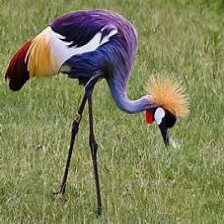

In [7]:
#Extracting the image and label for an index and displaying the image and the label. PIL image so we can display in browser
image, label = dataset[600]
print(f'Label: {label}')
image

I want to visualize the number of images for each class count to have an idea of the imbalances if they exist. I will now do this.

In [8]:
# I will import Counter to help with this
from collections import Counter
# Get the labels for images
labels = [dataset[i][1] for i in range(len(dataset))]
#count occurrences in each label
label_counts = Counter(labels)
print(label_counts)

Counter({262: 248, 163: 233, 333: 233, 410: 217, 446: 214, 118: 213, 334: 207, 166: 203, 365: 202, 431: 201, 396: 200, 157: 198, 109: 197, 307: 197, 355: 197, 324: 196, 54: 194, 354: 194, 426: 193, 400: 192, 40: 190, 180: 190, 297: 190, 427: 190, 380: 189, 34: 188, 77: 188, 310: 188, 7: 187, 21: 187, 38: 187, 89: 186, 171: 186, 270: 186, 87: 185, 316: 185, 96: 184, 100: 184, 235: 184, 271: 183, 391: 182, 419: 181, 1: 180, 120: 180, 2: 179, 13: 179, 19: 179, 97: 177, 136: 177, 138: 177, 207: 177, 217: 176, 238: 176, 337: 176, 213: 175, 249: 175, 287: 175, 296: 175, 389: 175, 442: 175, 86: 173, 260: 173, 351: 173, 434: 172, 14: 170, 288: 170, 384: 170, 230: 169, 433: 169, 42: 168, 57: 168, 81: 168, 129: 168, 88: 167, 251: 167, 359: 167, 360: 167, 405: 167, 0: 166, 11: 166, 52: 166, 55: 166, 135: 166, 172: 166, 192: 166, 346: 166, 10: 165, 46: 165, 74: 165, 99: 165, 125: 165, 191: 165, 232: 165, 264: 165, 418: 165, 16: 164, 35: 164, 41: 164, 73: 164, 119: 164, 130: 164, 154: 164, 226: 164

In [9]:
#check the number of classes
len(label_counts) #number of classes


450

Let's use matplotlib to visualize

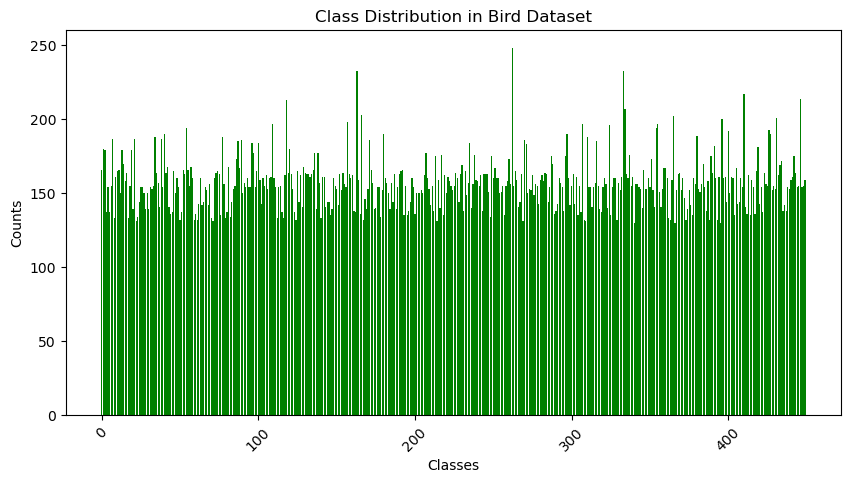

In [10]:
# Get classes and then values in separate lists.
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='green')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in Bird Dataset')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.show()



We have some imbalances that we will address. Also there are over 400 classes. I think I might only take 50 classes to train and see how that works out before attempting more. I would also like to see the actual names of the species of bird associated with the count. I need to get a dictionary that associated the target class with the folder name first before I can do this.

In [11]:
# Get a dictionary that associates the target class with folder names
class_targets = {v:k for k, v in dataset.data.class_to_idx.items()}
print(class_targets)
#first_10_classes = dict(list(class_targets.items())[:10])
#first_10_classes

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY', 2: 'ABYSSINIAN GROUND HORNBILL', 3: 'AFRICAN CROWNED CRANE', 4: 'AFRICAN EMERALD CUCKOO', 5: 'AFRICAN FIREFINCH', 6: 'AFRICAN OYSTER CATCHER', 7: 'AFRICAN PIED HORNBILL', 8: 'ALBATROSS', 9: 'ALBERTS TOWHEE', 10: 'ALEXANDRINE PARAKEET', 11: 'ALPINE CHOUGH', 12: 'ALTAMIRA YELLOWTHROAT', 13: 'AMERICAN AVOCET', 14: 'AMERICAN BITTERN', 15: 'AMERICAN COOT', 16: 'AMERICAN FLAMINGO', 17: 'AMERICAN GOLDFINCH', 18: 'AMERICAN KESTREL', 19: 'AMERICAN PIPIT', 20: 'AMERICAN REDSTART', 21: 'AMERICAN WIGEON', 22: 'AMETHYST WOODSTAR', 23: 'ANDEAN GOOSE', 24: 'ANDEAN LAPWING', 25: 'ANDEAN SISKIN', 26: 'ANHINGA', 27: 'ANIANIAU', 28: 'ANNAS HUMMINGBIRD', 29: 'ANTBIRD', 30: 'ANTILLEAN EUPHONIA', 31: 'APAPANE', 32: 'APOSTLEBIRD', 33: 'ARARIPE MANAKIN', 34: 'ASHY STORM PETREL', 35: 'ASHY THRUSHBIRD', 36: 'ASIAN CRESTED IBIS', 37: 'ASIAN DOLLARD BIRD', 38: 'AUCKLAND SHAQ', 39: 'AUSTRAL CANASTERO', 40: 'AUSTRALASIAN FIGBIRD', 41: 'AVADAVAT', 42: 'AZARAS SPINETAIL', 43

In [12]:
#Now we can see the counts for each bird species and we see that House Finch has the most and Snow Plover has the least
labels = [class_targets[dataset[i][1]] for i in range(len(dataset))]
#count occurrences in each label
label_counts = Counter(labels)
print(label_counts)


Counter({'HOUSE FINCH': 248, 'D-ARNAUDS BARBET': 233, 'OVENBIRD': 233, 'SWINHOES PHEASANT': 217, 'WOOD DUCK': 214, 'CASPIAN TERN': 213, 'OYSTER CATCHER': 207, 'DARK EYED JUNCO': 203, 'RED TAILED HAWK': 202, 'VIOLET GREEN SWALLOW': 201, 'SORA': 200, 'CRIMSON SUNBIRD': 198, 'CAMPO FLICKER': 197, 'MARABOU STORK': 197, 'RED BEARDED BEE EATER': 197, 'NORTHERN PARULA': 196, 'BANDED BROADBILL': 194, 'RAZORBILL': 194, 'VARIED THRUSH': 193, 'SPOONBILL': 192, 'AUSTRALASIAN FIGBIRD': 190, 'EASTERN MEADOWLARK': 190, 'LOGGERHEAD SHRIKE': 190, 'VEERY': 190, 'RUFUOS MOTMOT': 189, 'ASHY STORM PETREL': 188, 'BLACK VENTED SHEARWATER': 188, 'MCKAYS BUNTING': 188, 'AFRICAN PIED HORNBILL': 187, 'AMERICAN WIGEON': 187, 'AUCKLAND SHAQ': 187, 'BLUE MALKOHA': 186, 'DOUBLE BRESTED CORMARANT': 186, 'INDIAN PITTA': 186, 'BLUE GROUSE': 185, 'NORTHERN BEARDLESS TYRANNULET': 185, 'BREWERS BLACKBIRD': 184, 'BUFFLEHEAD': 184, 'GREATOR SAGE GROUSE': 184, 'INDIAN ROLLER': 183, 'SKUA': 182, 'TREE SWALLOW': 181, 'ABBOTTS 

#### Below I create a convenient function to view sample of birds from the images, given a dataset.

In [13]:
import random

# view multiple images
def view_multiple_images(dataset, count=8, figsize=(40,30)):
    #The number of rows for display
    rows = count//4
    if count%4 > 0: # if we cannot divide into equal rows. Then we have to add an additional row for the extra images
        rows += 1
    # We could shorten the code above, like this: rows = count // 4 + (count % 4 > 0)
    
    class_targets = {v:k for k, v in dataset.data.class_to_idx.items()}
    idx_list = random.sample(range(len(dataset)), count)
    for column, value in enumerate(idx_list):
        image, label = dataset[value]
        plt.subplot(rows, 4, column+1)
        plt.title(f'Label: {class_targets[label]}', fontsize=7)
        plt.axis('off')
        plt.imshow(image)
        plt.subplots_adjust(wspace=0.8, hspace=0.5)
        plt.tight_layout()
    plt.show()


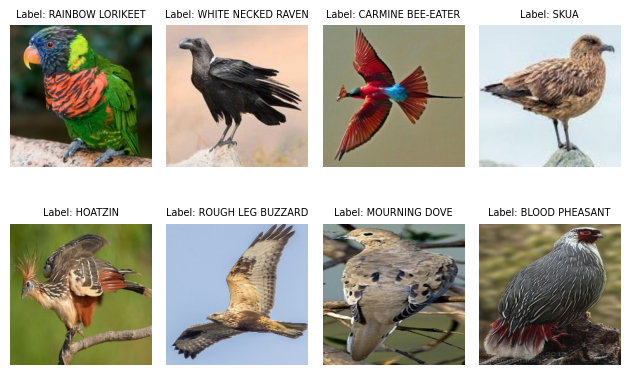

In [14]:
view_multiple_images(dataset)

### Create a dataset with a smaller subset of data

I created a small standalone Python program that will select a certain number of folders. This script will sort the folders and select the folders with the fewest images, which is still a good number for the class. This way, the number of images in each class is almost balanced. The program creates two new folders for training and validation (test folders can also be created). The program is shown below.

```python

import os
import shutil

def count_items_in_folder(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

def select_least_items_folder(input_folder, n=10):
    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir() ]
    # Create a list of tuples (folder_path, item_count)
    folder_item_counts = [(subfolder, count_items_in_folder(subfolder)) for subfolder in subfolders]

    # Sort the list by item count and select the least n folders
    least_items_folders = sorted(folder_item_counts, key=lambda x: x[1])[:n]
    
    return [folder for folder, _ in least_items_folders]

def copy_selected_folders(selected_folders, output_folder_train, input_folder_test_valid, output_folder_test_valid):
    """Copy selected folders to the output folder"""
    os.makedirs(output_folder_train, exist_ok=True)
    os.makedirs(output_folder_test_valid, exist_ok=True)

    for folder in selected_folders:
        folder_name = os.path.basename(folder)
        destination = os.path.join(output_folder_train, folder_name)
        shutil.copytree(folder, destination)

        input_test_valid_dir = os.path.join(input_folder_test_valid, folder_name)
        destination_test_valid = os.path.join(output_folder_test_valid, folder_name)
        shutil.copytree(input_test_valid_dir, destination_test_valid)


def main(input_folder_train, output_folder_train, input_folder_test_valid, output_folder_test_valid):
    selected_folders = select_least_items_folder(input_folder_train, 50)
    #copy_selected_folders(selected_folders, output_folder_train)
    copy_selected_folders(selected_folders, output_folder_train, input_folder_test_valid, output_folder_test_valid)


if __name__ == "__main__":
    img_dir_train = 'train'
    img_dir_small_train = 'train_small'

    # change test to valid for `test` string and `test_small` if you want to create validation folder
    img_dir_test_valid = 'test'
    img_dir_small_test_valid = 'test_small'
    
    #img_dir2 ="/home/kevin/Programming/Python/ComputerVision/Bird_Classification/bird-species/train_v1/ABBOTTS BABBLER"
    #c = count_items_in_folder(img_dir2)
    #c = select_least_items_folder(img_dir1)

    main(img_dir_train, img_dir_small_train, img_dir_test_valid, img_dir_small_test_valid)
```

In [15]:
# Variables pointing to folders
train_dir_small = './bird-species/train_small'
valid_dir_small = './bird-species/valid_small'
test_dir_small = './bird-species/test_small'

In [16]:
# Create a new dataset with transform. In the transform, we are resizing our image for faster processing. Let's try resizing to 128x128
# Notice in the transform, I am converting the image to Tensor so that PyTorch can process the data. We will also use DataLoader.
# Using DataLoader to wrap our dataset will allow us to batch or data for speed and process in parallel. We will use a batch size of 32 
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
train_dataset = BirdDataset(train_dir_small, transform=transform)
valid_dataset = BirdDataset(valid_dir_small, transform=transform)
test_dataset = BirdDataset(test_dir_small, transform=transform)
# We need to shuffle the training loader. This is crucial as it helps with: optimization, preventing overfitting, improve generalization..etc
# Shuffling is not necessary for validation and test set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Let's check the shape and our dataset and dataloader to see if the shapes and datatypes are valid

In [17]:
print(len(train_dataset))
print(train_dataset[300])
print(train_dataset[300][0].shape)

6671
(tensor([[[0.4078, 0.4118, 0.4118,  ..., 0.4510, 0.4471, 0.4471],
         [0.4039, 0.4078, 0.4078,  ..., 0.4510, 0.4510, 0.4471],
         [0.4078, 0.4078, 0.4118,  ..., 0.4510, 0.4549, 0.4510],
         ...,
         [0.4314, 0.4353, 0.4314,  ..., 0.3569, 0.3490, 0.3490],
         [0.4235, 0.4196, 0.4235,  ..., 0.3529, 0.3529, 0.3490],
         [0.4196, 0.4157, 0.4157,  ..., 0.3529, 0.3569, 0.3490]],

        [[0.5216, 0.5176, 0.5176,  ..., 0.5922, 0.5882, 0.5882],
         [0.5098, 0.5137, 0.5137,  ..., 0.5922, 0.5922, 0.5882],
         [0.5059, 0.5098, 0.5098,  ..., 0.5922, 0.5961, 0.5922],
         ...,
         [0.5647, 0.5686, 0.5725,  ..., 0.4706, 0.4627, 0.4627],
         [0.5608, 0.5569, 0.5569,  ..., 0.4667, 0.4667, 0.4627],
         [0.5569, 0.5529, 0.5490,  ..., 0.4667, 0.4706, 0.4627]],

        [[0.2471, 0.2471, 0.2471,  ..., 0.2471, 0.2431, 0.2353],
         [0.2392, 0.2431, 0.2431,  ..., 0.2431, 0.2392, 0.2353],
         [0.2392, 0.2431, 0.2471,  ..., 0.2392, 0.24

- Looks good so far.

In [18]:
# Use break in for loop to give us access to the first item so that we can check it.
for images, labels in valid_loader:
    break
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## 2. Create our Model with PyTorch
Here we will use `efficientnet` from `timm` as our base model. This requires to know the output of this base model to feed into our Linear layer. The output is 1280. We also need to get these outputs to use for our features to feed into our classifier

In [20]:
class BirdClassifierModel(nn.Module):
    def __init__(self, num_classes=50):
        super(BirdClassifierModel, self).__init__()
        # define structure
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # Below we get all the children from the model, turn it into a list then remove/cut off the last layer.
        #We then creates a new model from the layers returned.
        #self.features is a derived model with all the layers from the model except the last one.
        # we use * to unpack them for arguments to the sequential model
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        #Create model using Sequential for 
        self.classifier = nn.Sequential(
            #Flatten tensor to 2D since Linear layer requires 2D
            nn.Flatten(),
            #output size of efficientnet to 512 dimensional space 
            nn.Linear(1280, 512),
            nn.ReLU(), # activate function to apply non-linear transformation to learn more complex patterns
            nn.Dropout(0.5), # preventing overfitting
            nn.Linear(512, num_classes) #Final output on linear to num of predicted classes
         )
    def forward(self, x):
        # connect features to classifer from setup
        x = self.features(x)
        # Final output of classifier above is returned.
        x = self.classifier(x)
        return x


In [21]:
#create model
model = BirdClassifierModel()

In [27]:
#view parameters
model.parameters

<bound method Module.parameters of BirdClassifierModel(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate):

In [28]:
# Model info is long, so lets only show a few lines.
print(str(model)[:300])

BirdClassifierModel(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True


## 3. Train Model

Before training. We need to set up the Loss function and an optimizer. A learning rate will also be defined. We will also set the number of epochs and also create variables to keep track of training loss and validation loss. A device will also be created so that we can use `cuda`. Let's go.

In [29]:
epochs = 20
training_loss = []
validation_loss = []
lr = 0.001

#create our device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#send model to device
model.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    #Training
    model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc='Training'):
        imgs, labels = imgs.to(device), labels.to(device)
        #reset gradient from previous backward pass
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    training_loss.append(train_loss)

    #Validation
    model.eval()
    running_loss = 0.0
    #turn off backpropagation for validation
    with torch.no_grad():
        for imgs, labels in tqdm(valid_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    valid_loss = running_loss / len(valid_loader.dataset)
    validation_loss.append(valid_loss)
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {train_loss}, Validation loss: {valid_loss}")



Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/20 - Training loss: 1.2816189220598158, Validation loss: 0.25513468569517134


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/20 - Training loss: 0.41143344098562745, Validation loss: 0.1446511685103178


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/20 - Training loss: 0.24481188434297188, Validation loss: 0.0887840322284028


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/20 - Training loss: 0.2761728960505277, Validation loss: 0.187660391330719


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/20 - Training loss: 0.20154257379796145, Validation loss: 0.2158131831586361


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/20 - Training loss: 0.15120461998665696, Validation loss: 0.14560690803825854


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/20 - Training loss: 0.0968299602084236, Validation loss: 0.16554937025159597


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/20 - Training loss: 0.14092679084558557, Validation loss: 0.2519520765170455


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/20 - Training loss: 0.13816460507000883, Validation loss: 0.3021366523504257


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/20 - Training loss: 0.15203834705031305, Validation loss: 0.18559253066778184


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/20 - Training loss: 0.11969044739404212, Validation loss: 0.21127093668025917


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/20 - Training loss: 0.1416161713791946, Validation loss: 0.16466691488027574


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/20 - Training loss: 0.10719184595879305, Validation loss: 0.18229158625984565


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/20 - Training loss: 0.13094615491517272, Validation loss: 0.1374259058907628


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/20 - Training loss: 0.08192671392594059, Validation loss: 0.0997274062037468


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/20 - Training loss: 0.07188644162833628, Validation loss: 0.22386259685456752


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/20 - Training loss: 0.15084044066450572, Validation loss: 0.39322322130203247


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/20 - Training loss: 0.10438925956810495, Validation loss: 0.22131700800172985


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/20 - Training loss: 0.085360089246567, Validation loss: 0.16425082285609097


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/20 - Training loss: 0.08152641907136154, Validation loss: 0.19318124890327454


## 3. Visualize Training Results

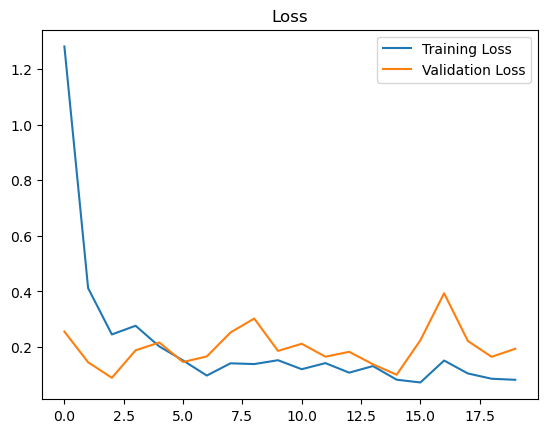

In [30]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

This model has potential as both the Traning Loss and Validation loss has decreased. Let's check the accuracy and do some more evaluation.

## 4. Test Accuracy

In [31]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct/total

# After training, calculate accuracy on the test set

test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 98.4%


## 5. Conclusion
The accuracy on the test set is fairly good. The model has achieved 98.5% accuracy. Accuracy alone does not tell the whole story. I will need to consider the False Positives and False Negatives. I will need to explore other metrics like precision, recall and F1-score. For now I will save this model and it's state dictionary. 

In [32]:
# We can only save the model's state dictionary as this is more efficient than saving the entire model
torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_state_dict.pth')

#### Reminder on how to reuse this model in application
```python
model = BirdClassifierModel() 
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()
```

# 